Investigating the error dues to offset from image plane.
-----------------------------------------------------------------

The conclusion is that the additive error in posiion on the detector due to an offset dx form the image plane has standard deviation

\sigma_a * dx * M

where M is magnification and \sigma_a the angular acceptance of the CRL. I.e the error is typically 100 times smaller than dx. So a 10 micron offset gives a 0.1 micron blurring which can be considered neglegible for mot cases.

In [16]:
import unittest
import matplotlib.pyplot as plt
import numpy as np
from darkmod.crl import CompundRefractiveLens
import sympy as sp

In [17]:
number_of_lenses = 50
lens_space = 2 * 1e-3
lens_radius = 50 * 1e-6
refractive_decrement = 1.65 * 1e-6
magnification = 10
crl = CompundRefractiveLens(number_of_lenses,
                            lens_space,
                            lens_radius,
                            refractive_decrement,
                            magnification)

In [18]:
# this is the setup of the crl at perfect imaging conditions
D1 = np.eye(2,2)
d1 = crl.d1
D1[0,1] = d1
D2 = np.eye(2,2)
D2[0,1] = crl.d2
M_N = crl.M_N

In [19]:
# let's say we are in a 25 micron box we investiaget the brodeing at the corner.
ys = 1000 * 1e-6
delta_x = 25 * 1e-6

# we assume some resonable angular gaussian distirbution.
std = 0.000310427118005271
alphas = np.random.normal(0, std, size=(50000,))

# we create some rays.
rays = np.array([np.ones(len(alphas))*ys, alphas])
D1[0,1] = d1 + delta_x

# propagate these to the detector
ray_final = (D2 @ M_N @ D1) @ rays
y = ray_final[0]

-0.010000000033812517 0.01
7.801282459621201e-08 7.760677950131774e-08


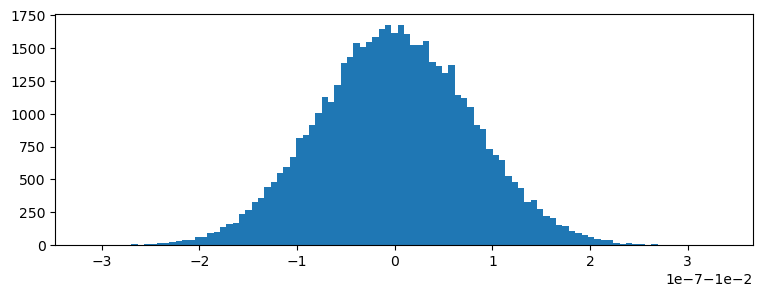

In [20]:
# lets see what the blurring looks like
plt.figure(figsize=(9,3))
plt.hist(y, bins=100)
print(y.mean(), crl.magnification*ys)
print(y.std(), crl.magnification*std*delta_x)

plt.show()


In [21]:
ys = 0 * 1e-6
delta_x = 25 * 1e-6

# we assume some resonable angular gaussian distirbution.
std = 0.000310427118005271
delta_xs = np.linspace(-100, 100, 200)*1e-6
ystd = np.zeros_like(delta_xs)
for i in range(len(delta_xs)):
    alphas = np.random.normal(0, std, size=(5000,))

    # we create some rays.
    rays = np.array([np.ones(len(alphas))*ys, alphas])
    D1[0,1] = d1 + delta_xs[i]
    # propagate these to the detector
    ray_final = (D2 @ M_N @ D1) @ rays
    ystd[i]=  ray_final[0].std()

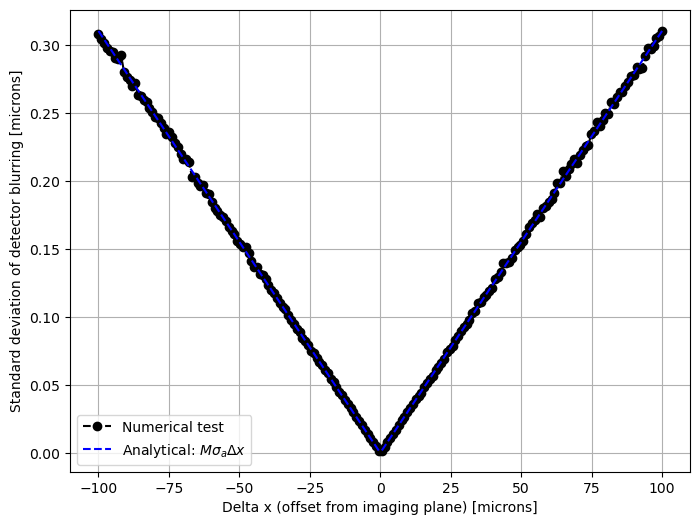

In [22]:
plt.figure(figsize=(8,6))
plt.plot(delta_xs*1e6, ystd*1e6, 'ko--', label='Numerical test')
plt.plot(delta_xs*1e6, crl.magnification*std*np.abs(delta_xs)*1e6, 'b--',label='Analytical: $M\sigma_a\Delta x$')
plt.xlabel('Delta x (offset from imaging plane) [microns]')
plt.ylabel('Standard deviation of detector blurring [microns]')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# let us verify our analytical guess:

N, f, T, dx, y, alpha, M = sp.symbols('N f T dx y alpha M')

r = sp.Matrix([y, alpha])

t2 = 1 - (T/(2*f))
t1 = sp.sqrt( 1 - (t2)**2 )
phi = sp.atan( t1 / t2 )

Nc = sp.cos(N * phi)
Ns = sp.sin(N * phi)
s = sp.sin(phi)

M_N = sp.Matrix([[Nc,             f*Ns*s],
                [-Ns / (s*f),    Nc    ]])

d2 = -(M + M_N[0, 0]) / M_N[1, 0]

d1 =  -(d2*M_N[1, 1] + M_N[0, 1]) / (M_N[0, 0] + d2*M_N[1, 0])

D2 = sp.Matrix([[1,    d2],
                [0,    1    ]])

D1 = sp.Matrix([[1,   d1],
                [0,   1    ]])

D1p = sp.Matrix([[1,   d1+dx],
                [0,   1    ]])


y1 = D2 * M_N * D1 * r
y2 = D2 * M_N * D1p * r

error = sp.simplify(y1[0] - sp.simplify(y2[0]))
print(sp.latex(error))

M \alpha dx
